(150, 150, 1)


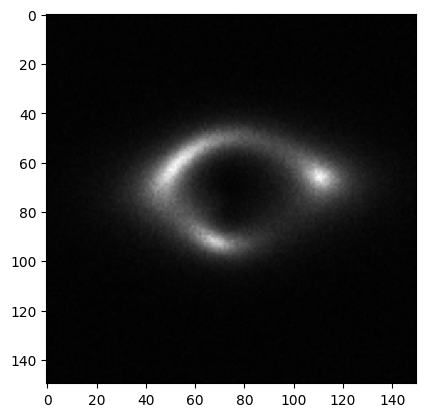

In [1]:
import os
import numpy 
import matplotlib.pyplot as plt
import pandas
import torch    
import torch.nn as nn

path = "dataset//train//no//2.npy"

image = numpy.load(path)
#reshape image to size,size,1
image = numpy.reshape(image, (image.shape[1], image.shape[2], 1))
print(image.shape)

plt.imshow(image, cmap='gray')
plt.show()

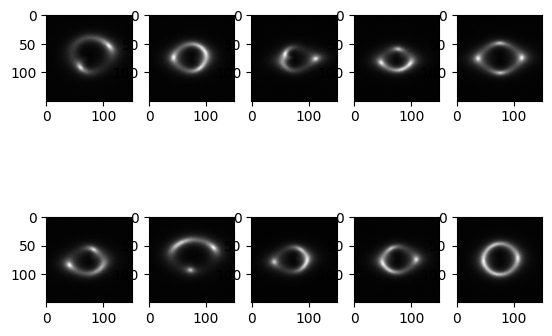

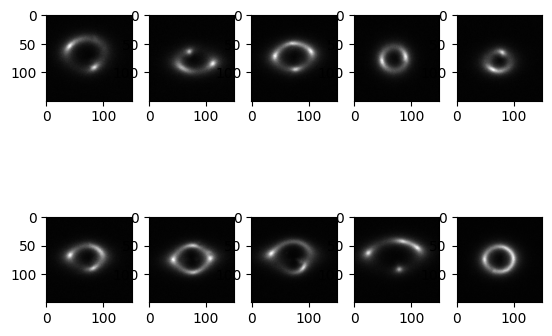

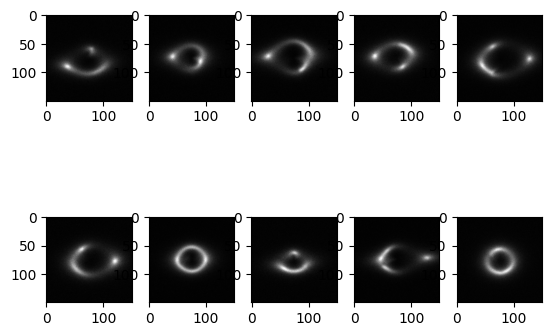

In [2]:
#plot 10 images of each class in grid

#no
path = "dataset//train//no//"
files = os.listdir(path)
fig = plt.figure()
for i in range(10):
    image = numpy.load(path + files[i])
    image = numpy.reshape(image, (image.shape[1], image.shape[2], 1))
    fig.add_subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')

plt.show()

#sphere
path = "dataset//train//sphere//"
files = os.listdir(path)
fig = plt.figure()
for i in range(10):
    image = numpy.load(path + files[i])
    image = numpy.reshape(image, (image.shape[1], image.shape[2], 1))
    fig.add_subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')

plt.show()

#vort
path = "dataset//train//vort//"
files = os.listdir(path)
fig = plt.figure()
for i in range(10):
    image = numpy.load(path + files[i])
    image = numpy.reshape(image, (image.shape[1], image.shape[2], 1))
    fig.add_subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')

plt.show()



In [3]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, mode='train', transform=None):
        self.mode = mode
        self.transform = transform
        self.data = []
        self.labels = []
        self.class_names = {0: "no", 1: "sphere", 2: "vort"}

        if self.mode == 'train':
            self.load_data("dataset//train//no//", 0)
            self.load_data("dataset//train//sphere//", 1)
            self.load_data("dataset//train//vort//", 2)
        elif self.mode == 'test':
            self.load_data("dataset//val//no//", 0)
            self.load_data("dataset//val//sphere//", 1)
            self.load_data("dataset//val//vort//", 2)

    def load_data(self, directory, label):
        files = os.listdir(directory)
        for file in files:
            image = np.load(os.path.join(directory, file))
            image = np.reshape(image, (image.shape[1], image.shape[2], 1))
            self.data.append(image)
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


/home/arnesh/ai/yolo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


def multiclass_auc_score(y_true, y_pred):
    n_classes = y_true.shape[1]
    auc_values = []
    for i in range(n_classes):
        auc_values.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
    return np.mean(auc_values)


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# import torch
# import torch.nn as nn

# # Define the basic block for ResNet
# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_channels, out_channels, stride=1):
#         super(BasicBlock, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)

#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)

#         # Shortcut connection
#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != self.expansion * out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * out_channels)
#             )

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)

#         out += self.shortcut(x)
#         out = self.relu(out)

#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, layers, num_classes=10):
#         super(ResNet, self).__init__()

#         self.in_channels = 64
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         # Residual layers
#         self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

#         # Global average pooling and fully connected layer
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#     def _make_layer(self, block, out_channels, blocks, stride=1):
#         layers = []
#         layers.append(block(self.in_channels, out_channels, stride))
#         self.in_channels = out_channels * block.expansion
#         for _ in range(1, blocks):
#             layers.append(block(self.in_channels, out_channels))
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         return x


# #resnet50
# def ResNet50():
#     return ResNet(BasicBlock, [3, 4, 6, 3] , num_classes=3)

# model = ResNet50().to(device)

# # Print the model architecture
# print(model)


In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224, 224))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

train_dataset = CustomDataset(mode='train', transform=train_transform)
test_dataset = CustomDataset(mode='test', transform=test_transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [7]:
#using pretrained model for transfer learning to save time

#mobilenetv2
import torchvision.models as models
model = models.mobilenet_v2(pretrained=True)
#convert to 1 channel
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(1280, 3)
model = model.to(device)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [10]:
#sample input
sample = torch.randn(1, 1, 224, 224).to(device)
model(sample)

tensor([[-0.5304,  0.1731,  0.1572]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [26]:
from alive_progress import alive_bar
import warnings
warnings.filterwarnings("ignore")


EPOCHS = 500
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

best_acc = 0.0
best_auc = 0.0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    with alive_bar(len(train_loader) , force_tty=True) as bar:
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.float()
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_accuracy += (preds == labels).sum().item()
            bar()
    print(f'Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {train_loss / len(train_loader.dataset):.4f}, Train Accuracy: {train_accuracy / len(train_loader.dataset) * 100:.2f}%')
    
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        with alive_bar(len(test_loader) , force_tty=True) as bar:
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                images = images.float()
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                test_accuracy += (preds == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                bar()

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    #ravel y_pred
    y_pred = y_pred.ravel()
    #one hot encoding with np.eye
    y_true_one_hot = np.eye(3)[y_true]
    y_pred_one_hot = np.eye(3)[y_pred]
    # Calculate ROC AUC score
    auc = multiclass_auc_score(y_true_one_hot, y_pred_one_hot)
    print(f'Epoch [{epoch + 1}/{EPOCHS}], Test Loss: {test_loss / len(test_loader.dataset):.4f}, Test Accuracy: {test_accuracy / len(test_loader.dataset) * 100:.2f}%, AUC: {auc:.4f}')
    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), f'models/best_model_mobilnet_{auc}.pth')
            

|                                        | ▁▃▅ 0/1875 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 1875/1875 [100%] in 1:32.0 (20.38/s) 
Epoch [1/500], Train Loss: 0.0516, Train Accuracy: 59.79%
|████████████████████████████████████████| 469/469 [100%] in 8.3s (57.51/s)     
Epoch [1/500], Test Loss: 0.0373, Test Accuracy: 75.03%, AUC: 0.8127
|████████████████████████████████████████| 1875/1875 [100%] in 1:29.5 (20.96/s) 
Epoch [2/500], Train Loss: 0.0283, Train Accuracy: 82.83%
|████████████████████████████████████████| 469/469 [100%] in 7.7s (60.90/s)     
Epoch [2/500], Test Loss: 0.0346, Test Accuracy: 82.19%, AUC: 0.8664
|████████████████████████████████████████| 1875/1875 [100%] in 1:27.8 (21.35/s) 
Epoch [3/500], Train Loss: 0.0227, Train Accuracy: 86.68%
|████████████████████████████████████████| 469/469 [100%] in 7.0s (67.14/s)     
Epoch [3/500], Test Loss: 0.1097, Test Accuracy: 73.93%, AUC: 0.8045
|████████████████████████████████████████| 1875/1875 [100%] in 1:27.8 (21.37/s) 
Epoch [4/500], Train Loss: 0.0202, Train Accuracy: 8

In [15]:
#roc curve multiclass
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt



def plot_roc_curve(y_true, y_pred, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])


    plt.figure( figsize=(10, 10))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linewidth=4)
    colors = ['aqua', 'darkorange', 'cornflowerblue']

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])

    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic pf multi-class')
    plt.legend(loc="lower right")

    plt.show()

|████████████████████████████████████████| 469/469 [100%] in 7.6s (61.57/s)     
AUC: 0.9741


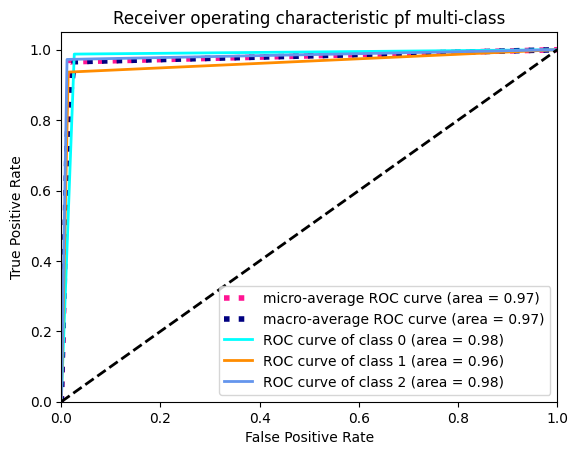

|████████████████████████████████████████| 1875/1875 [100%] in 35.9s (52.23/s)  
AUC: 0.9999


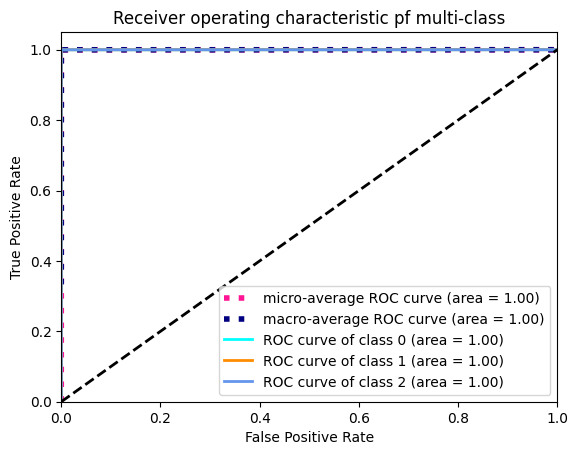

In [23]:
#Evaluating the model
#mobilenetv2
from alive_progress import alive_bar
import torchvision.models as models
import warnings
warnings.filterwarnings("ignore")

model = models.mobilenet_v2(pretrained=False)
#convert to 1 channel
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(1280, 3)
model = model.to(device)
model.load_state_dict(torch.load('/run/media/Deeplense GSOC/task1/models/best_model_mobilnet_0.9741.pth'))

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    with alive_bar(len(test_loader) , force_tty=True) as bar:
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.float()
            # Forward pass

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            bar()

y_true = np.array(y_true)
y_pred = np.array(y_pred)
#ravel y_pred
y_pred = y_pred.ravel()
#one hot encoding with np.eye
y_true_one_hot = np.eye(3)[y_true]
y_pred_one_hot = np.eye(3)[y_pred]
# Calculate ROC AUC score
auc = multiclass_auc_score(y_true_one_hot, y_pred_one_hot)
print(f'AUC: {auc:.4f}')

plot_roc_curve(y_true_one_hot, y_pred_one_hot, n_classes=3)

#train auc  
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    with alive_bar(len(train_loader) , force_tty=True) as bar:
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.float()
            # Forward pass

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            bar()

y_true = np.array(y_true)
y_pred = np.array(y_pred)
#ravel y_pred
y_pred = y_pred.ravel()
#one hot encoding with np.eye
y_true_one_hot = np.eye(3)[y_true]
y_pred_one_hot = np.eye(3)[y_pred]

# Calculate ROC AUC score
auc = multiclass_auc_score(y_true_one_hot, y_pred_one_hot)
print(f'AUC: {auc:.4f}')

plot_roc_curve(y_true_one_hot, y_pred_one_hot, n_classes=3)



In [4]:
#mobilenet_v3_large

import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, mode='train', transform=None):
        self.mode = mode
        self.transform = transform
        self.data = []
        self.labels = []
        self.class_names = {0: "no", 1: "sphere", 2: "vort"}

        if self.mode == 'train':
            self.load_data("dataset//train//no//", 0)
            self.load_data("dataset//train//sphere//", 1)
            self.load_data("dataset//train//vort//", 2)
        elif self.mode == 'test':
            self.load_data("dataset//val//no//", 0)
            self.load_data("dataset//val//sphere//", 1)
            self.load_data("dataset//val//vort//", 2)

    def load_data(self, directory, label):
        files = os.listdir(directory)
        for file in files:
            image = np.load(os.path.join(directory, file)).astype(np.float32)
            image = np.reshape(image, (image.shape[1], image.shape[2], 1))
            self.data.append(image)
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label




transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([transforms.CenterCrop(100)], p=0.40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation([-90,90]),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(torch.float32).repeat(3,1,1)),
    transforms.Resize((224,224)),
])


test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(torch.float32).repeat(3,1,1)),
    transforms.Resize((224,224)),
])



train_dataset = CustomDataset(mode='train', transform=transform)
test_dataset = CustomDataset(mode='test', transform=test_transform)


In [5]:
import torch

print(len(train_dataset))
print(len(test_dataset))
print(train_dataset[0][0].shape)


30000
7500
torch.Size([3, 224, 224])


In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [7]:
import torchvision
import torch
import torch.nn as nn


device = 'cpu' 
model = torchvision.models.mobilenet_v3_large(pretrained=True);
model.classifier = nn.Sequential(
    nn.Linear(960, 3)
)
model.to(device)
     

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [8]:
#sample input
sample = torch.randn(1, 3, 224, 224).to(device)
model(sample)

tensor([[-0.2833, -0.0088,  0.1760]], grad_fn=<AddmmBackward0>)

In [14]:
from torch.optim import Adam,AdamW

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters() , 0.0001)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 500)


In [18]:
from alive_progress import alive_bar
import warnings
warnings.filterwarnings("ignore")

#load model
model.load_state_dict(torch.load('models/mobileNEtV3Large.pth'))


EPOCHS = 500
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

best_acc = 0.0
best_auc = 0.9877

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    with alive_bar(len(train_loader) , force_tty=True) as bar:
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.float()
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_accuracy += (preds == labels).sum().item()
            #reduce learning rate on plateau
            #scheduler.step(train_loss)
            #scheduler.step()
            bar()
    print(f'Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {train_loss / len(train_loader.dataset):.4f}, Train Accuracy: {train_accuracy / len(train_loader.dataset) * 100:.2f}%')
    
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        with alive_bar(len(test_loader) , force_tty=True) as bar:
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                images = images.float()
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                test_accuracy += (preds == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                bar()

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    #ravel y_pred
    y_pred = y_pred.ravel()
    #one hot encoding with np.eye
    y_true_one_hot = np.eye(3)[y_true]
    y_pred_one_hot = np.eye(3)[y_pred]
    # Calculate ROC AUC score
    auc = multiclass_auc_score(y_true_one_hot, y_pred_one_hot)
    print(f'Epoch [{epoch + 1}/{EPOCHS}], Test Loss: {test_loss / len(test_loader.dataset):.4f}, Test Accuracy: {test_accuracy / len(test_loader.dataset) * 100:.2f}%, AUC: {auc:.4f}')
    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), f'models/mobileNEtV3Large.pth')
            

|████████████████████████████████████████| 1875/1875 [100%] in 1:12.8 (25.77/s) 
Epoch [1/500], Train Loss: 0.0027, Train Accuracy: 98.54%
|████████████████████████████████████████| 469/469 [100%] in 7.2s (64.80/s)     
Epoch [1/500], Test Loss: 0.0039, Test Accuracy: 98.21%, AUC: 0.9866
|████████████████████████████████████████| 1875/1875 [100%] in 1:13.9 (25.36/s) 
Epoch [2/500], Train Loss: 0.0028, Train Accuracy: 98.51%
|████████████████████████████████████████| 469/469 [100%] in 7.5s (62.67/s)     
Epoch [2/500], Test Loss: 0.0040, Test Accuracy: 98.16%, AUC: 0.9862
|████████████████████████████████████████| 1875/1875 [100%] in 1:15.0 (25.01/s) 
Epoch [3/500], Train Loss: 0.0028, Train Accuracy: 98.51%
|████████████████████████████████████████| 469/469 [100%] in 8.3s (56.10/s)     
Epoch [3/500], Test Loss: 0.0039, Test Accuracy: 98.37%, AUC: 0.9878
|████████████████████████████████████████| 1875/1875 [100%] in 1:15.7 (24.77/s) 
Epoch [4/500], Train Loss: 0.0029, Train Accuracy: 9

KeyboardInterrupt: 

In [61]:
from alive_progress import alive_bar
import warnings
import torch.nn.functional as F
warnings.filterwarnings("ignore")

# Load model
model.load_state_dict(torch.load('models/mobileNEtV3Large.pth' , map_location=torch.device('cpu')))

model.eval()
test_loss = 0.0
test_accuracy = 0.0
y_true = []
y_pred_probs = []  # Store predicted probabilities instead of predicted labels

with torch.no_grad():
    with alive_bar(len(test_loader), force_tty=True) as bar:
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.float()
            
            # Forward pass
            outputs = model(images)

            _, preds = torch.max(outputs, 1)
            test_accuracy += (preds == labels).sum().item()

            # Softmax to get predicted probabilities
            probs = F.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(probs.cpu().numpy())
            bar()

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)



|                                        | ▁▃▅ 0/469 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 469/469 [100%] in 45.7s (10.27/s)    


AUROC: 0.9977509379386902


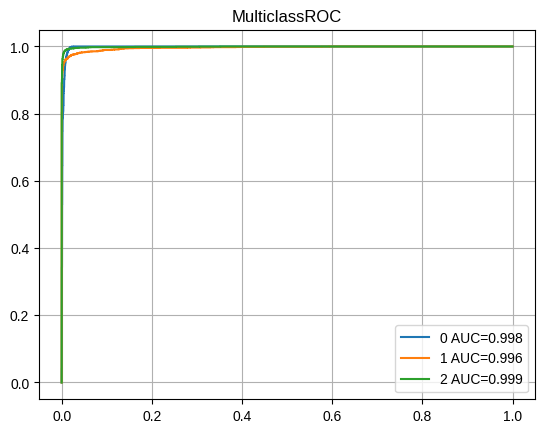

In [65]:
from torchmetrics import AUROC

# Flatten the true labels and predicted probabilities
flat_y_true = y_true.reshape(-1)
flat_y_pred_probs = y_pred_probs.reshape(-1, y_pred_probs.shape[-1])

auroc = AUROC(task="multiclass", num_classes=3)
auroc_val = auroc(torch.from_numpy(flat_y_pred_probs), torch.from_numpy(flat_y_true))
print(f"AUROC: {auroc_val.item()}")
#roc curve multiclass torchmetrics
from torchmetrics import ROC 

roc = ROC(num_classes=3 , task="multiclass")
fpr, tpr, thresholds = roc(torch.from_numpy(flat_y_pred_probs), torch.from_numpy(flat_y_true))
fig_, ax_ = roc.plot(score=True)

In [47]:
#AUC Score of each class
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

auc_ = []
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc_x = auc(fpr, tpr)
    print(f'Class {i} AUC: {roc_auc_x:.6f}')
    auc_.append(roc_auc_x)
    roc_auc[i] = (roc_auc_x)

print(f'Mean AUC: {np.mean(auc_):.4f}')


Class 0 AUC: 0.997853
Class 1 AUC: 0.996304
Class 2 AUC: 0.999095
Mean AUC: 0.9978
